# **CHECKPOINT 6:** Systematic Errors due to background model

## S1867522

In [1]:
# libraries used
import numpy as np
import matplotlib.pyplot as plt
import math
from iminuit import Minuit
from scipy import integrate

## **PART 1**

**(i)** Fit to these data with the above model to determine the best fit parameters for F, A, and M

**(ii)** Determine the statistical errors on each fit parameter

**(iii)** Present the best fit values and errors on all parameters in a clear way

**(iv)** Make sure the number of digits quoted is sensible - quote errors to 2 significant digits

In [2]:
# load data into a numpy array 
data = np.loadtxt("datafile-higgs.txt")

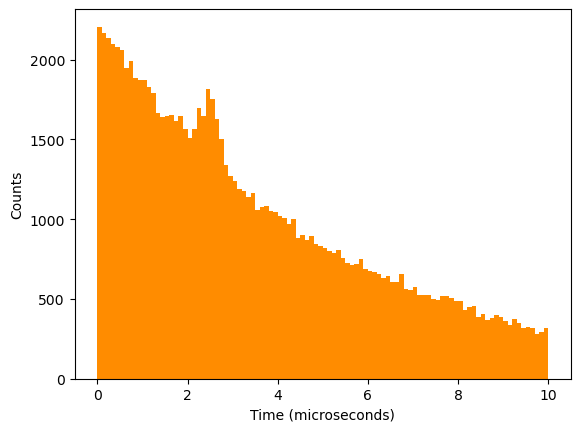

In [3]:
# plot histogram
plt.hist(data, bins = 100, color = "darkorange")
plt.xlabel("Time (microseconds)")
plt.ylabel("Counts")
plt.show;

**Description of model:** Fraction F = 0.98 of events from a background exponential ~ exp(-m/A) where A = 5. A fraction (1 - F) = 0.02 of a signal Gaussian. Gaussian mean M = 2.5 with a width of 0.2. Range of events [0,10]

In [4]:
# define combined PDF function normalized for a given range
# exponential decay (background) + gaussian (signal)

def pdf_comb (x, F, M, A):

    # given Gaussian width
    sigma = 0.2

    # range [0,10]
    a = 0
    b = 10

    return F*((1/A)*np.exp(-x/A) / (np.exp(-a/A) - np.exp(-b/A) )) + (1-F)* ( (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x-M)**2 / (2*sigma**2))  )


In [5]:
# Define the negative of the log of the joint likelihood for the normalized combined function

def NLL_func_comb(F,M, A):

    return -np.sum(np.log(pdf_comb(data, F, M, A)))

In [6]:
# Estimate best value of lifetime by minimising NLL using Minuit

m_comb = Minuit(NLL_func_comb, F = 0.9, A = 2.2, M = 2.5)

m_comb.errordef = Minuit.LIKELIHOOD
m_comb.migrad()  # run optimiser
m_comb.hesse()   # run covariance estimator

print(m_comb.values)  # print estimated values
print(m_comb.errors)  # print error of the estimated values

<ValueView F=0.9796055305629415 M=2.4985427310632864 A=5.0078637654208915>
<ErrorView F=0.0011549221484484823 M=0.014565482031871736 A=0.030746038870231897>


**Best fit parameter values with errors:**

In [7]:
print("F (fraction) = " + str(round(m_comb.values[0],4)) + " +/- " + str(round(m_comb.errors[0],4)))
print("A (decay) = " + str(round(m_comb.values[2],3)) + " +/- " + str(round(m_comb.errors[2],3)))
print("M (mean) = " + str(round(m_comb.values[1],3)) + " +/- " + str(round(m_comb.errors[1],3)))

F (fraction) = 0.9796 +/- 0.0012
A (decay) = 5.008 +/- 0.031
M (mean) = 2.499 +/- 0.015


## **PART 2**

**(i)** Determine a systematic error due to background model on the mean of the Gaussian (M) by the "shift" method

**(ii)** Fit to the same data using the same Gaussian signal model but now using a 2nd order polynomial background model

In [8]:
# define combined PDF function normalized for a given range 
# polynomial (background) + gaussian (signal)

def pdf_comb_2 (x, F, M, b, c):

    # given Gaussian width
    sigma = 0.2

    # range [0,10]

    # normalized gaussian PDF
    gaussian = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(np.array(x)-M)**2 / (2*(sigma**2))) 

    # normalized polynomial for the background
    polyn = lambda x: (1 + b*x + c*(x**2))
    integ = integrate.quad(polyn,0,10)[0]
    pdf_polyn = (1 + b*np.array(x) + c*np.array(x**2)) 

    # total PDF
    pdf_tot = F*(pdf_polyn/integ) + (1-F)* ( gaussian )
    pdf_tot[pdf_tot<1e-4] = 1e-4

    return pdf_tot

In [9]:
# Define the negative of the log of the joint likelihood for the normalized combined function

def NLL_func_comb_2(F, M,b,c):

    return -np.sum(np.log(pdf_comb_2(data, F, M,b,c)))

In [10]:
# Estimate best value of lifetime by minimising NLL using Minuit

m_comb_2 = Minuit(NLL_func_comb_2, F = 0.9, M = 2.5, b = -0.016, c=0.007)

m_comb_2.errordef = Minuit.LIKELIHOOD
m_comb_2.migrad()  # run optimiser
m_comb_2.hesse()   # run covariance estimator

print(m_comb_2.values)  # print estimated values
print(m_comb_2.errors)  # print error of the estimated values

<ValueView F=0.9820234223243929 M=2.494308689999232 b=-0.1577928963650138 c=0.007295158425674312>
<ErrorView F=0.0011612954398321376 M=0.015626135865595442 b=0.0013469545231973997 c=0.00014938806437945595>


**(iii)** Present the results clearly as  M = Value +- Estat +- Esyst

In [11]:
# calculating systematic errors
F_syst = m_comb.values[0] - m_comb_2.values[0] 
M_syst = m_comb.values[1] - m_comb_2.values[1] 

print("V = " + "Value" + " +/- " + "Stat Error"+ " +/- " + "Syst Error")
print("F = " + str(round(m_comb.values[0],4)) + " +/- " + str(round(m_comb.errors[0],4))+ " +/- " + str(round(F_syst,4)))
print("M = " + str(round(m_comb.values[1],3)) + " +/- " + str(round(m_comb.errors[1],3))+ " +/- " + str(round(M_syst,4)))

V = Value +/- Stat Error +/- Syst Error
F = 0.9796 +/- 0.0012 +/- -0.0024
M = 2.499 +/- 0.015 +/- 0.0042


**(iv)** Present the resutls as  M = Value +- Etot

In [12]:
# calculating total errors
F_tot = np.sqrt(F_syst**2 + m_comb.errors[0]**2)
M_tot = np.sqrt(M_syst**2 + m_comb.errors[1]**2)

print("V = " + "Value" + " +/- " + "Tot Error")
print("F = " + str(round(m_comb.values[0],4)) + " +/- " + str(round(F_tot,4)))
print("M = " + str(round(m_comb.values[1],3)) + " +/- " + str(round(M_tot,3)))

V = Value +/- Tot Error
F = 0.9796 +/- 0.0027
M = 2.499 +/- 0.015


**(v)** Comment on the importance of the systematic error compared to the statistical error for the measurement of M

The statistical error comes from assuming that everything done for the fitting is the ideal case (assumes that the PDF is the correct PDF for the data, that the background is understood perfectly, that the data is measured perfectly, etc).
While the systematic errors come from our lack of knowledge of many things. In this case the systematic error on the mean is not really big so the calculated total error and the statistical one is the sme for 2 significant figures.

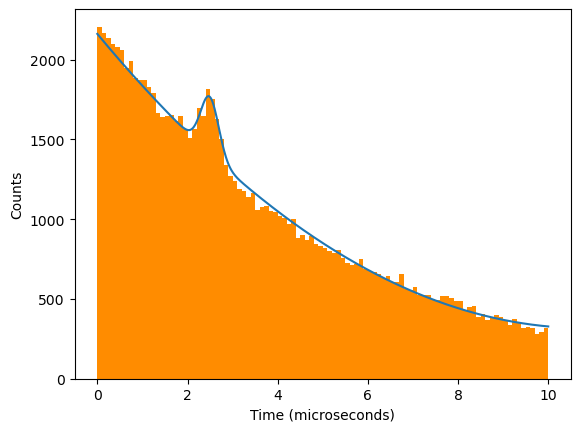

In [21]:
# plot histogram with fitted function
x = np.linspace(0, 10 ,1000)
y = pdf_comb_2(x, m_comb_2.values[0], m_comb_2.values[1], m_comb_2.values[2], m_comb_2.values[3])

plt.hist(data, bins = 100, color = "darkorange")
plt.plot(x, y*10000)
plt.xlabel("Time (microseconds)")
plt.ylabel("Counts")
plt.show;

## **PART 3**

**(i)** Do the same as part 2, but now using a straight line background model (bad model - this is harder)

In [14]:
# define combined PDF function normalized for a given range taken into account the Decay Time Acceptance
# exponential decay (background) + gaussian (signal)

def pdf_comb_3 (x, F, M, b):

    # given Gaussian width
    sigma = 0.2

    #a = 1 # fixed value
    #b = -0.016
    #c = 0.007

    # range [0,10]

    gaussian = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(np.array(x)-M)**2 / (2*(sigma**2))) 

    polyn = lambda x: (1 + b*x)
    integ = integrate.quad(polyn,0,10)[0]
    pdf_polyn = (1 + b*np.array(x)) 

    pdf_tot = F*(pdf_polyn/integ) + (1-F)* ( gaussian )
    pdf_tot[pdf_tot<1e-4] = 1e-4

    return pdf_tot

In [15]:
# Define the negative of the log of the joint likelihood for the normalized combined function

def NLL_func_comb_3(F, M,b):

    return -np.sum(np.log(pdf_comb_3(data, F, M,b)))

In [16]:
# Estimate best value of lifetime by minimising NLL using Minuit

m_comb_3 = Minuit(NLL_func_comb_3, F = 0.9, M = 2.5, b = -0.09)

m_comb_3.errordef = Minuit.LIKELIHOOD
m_comb_3.migrad()  # run optimiser
m_comb_3.hesse()   # run covariance estimator

print(m_comb_3.values)  # print estimated values
print(m_comb_3.errors)  # print error of the estimated values

<ValueView F=0.9801180777081477 M=2.4654096627651554 b=-0.0904042750258938>
<ErrorView F=0.001161225783457823 M=0.01513210259932867 b=0.00022291158439353693>


**(ii)** Present the result cleary as  M +- Estat +- Esyst

In [17]:
# calculating systematic errors
F_syst_3 = m_comb.values[0] - m_comb_3.values[0] 
M_syst_3 = m_comb.values[1] - m_comb_3.values[1] 

print("V = " + "Value" + " +/- " + "Stat Error"+ " +/- " + "Syst Error")
print("F = " + str(round(m_comb.values[0],4)) + " +/- " + str(round(m_comb.errors[0],4))+ " +/- " + str(round(F_syst_3,5)))
print("M = " + str(round(m_comb.values[1],3)) + " +/- " + str(round(m_comb.errors[1],3))+ " +/- " + str(round(M_syst_3,3)))

V = Value +/- Stat Error +/- Syst Error
F = 0.9796 +/- 0.0012 +/- -0.00051
M = 2.499 +/- 0.015 +/- 0.033


**(iii)** Present the result as  M +- Etot

In [18]:
# calculating total errors
F_tot_3 = np.sqrt(F_syst_3**2 + m_comb.errors[0]**2)
M_tot_3 = np.sqrt(M_syst_3**2 + m_comb.errors[1]**2)

print("V = " + "Value" + " +/- " + "Tot Error")
print("F = " + str(round(m_comb.values[0],4)) + " +/- " + str(round(F_tot_3,4)))
print("M = " + str(round(m_comb.values[1],3)) + " +/- " + str(round(M_tot_3,3)))

V = Value +/- Tot Error
F = 0.9796 +/- 0.0013
M = 2.499 +/- 0.036


**(iv)** Comment on the importance of the systematic error compared to the statistical error for the measurement of M

The statistical error comes from assuming that everything done for the fitting is the ideal case (assumes that the PDF is the correct PDF for the data, that the background is understood perfectly, that the data is measured perfectly, etc).
While the systematic errors come from our lack of knowledge of many things. In this case is easy to see in the plot below how the linear model for the background is not appropiate, and it can be seen how the systematic error has a big contribution to the total error at the end. 

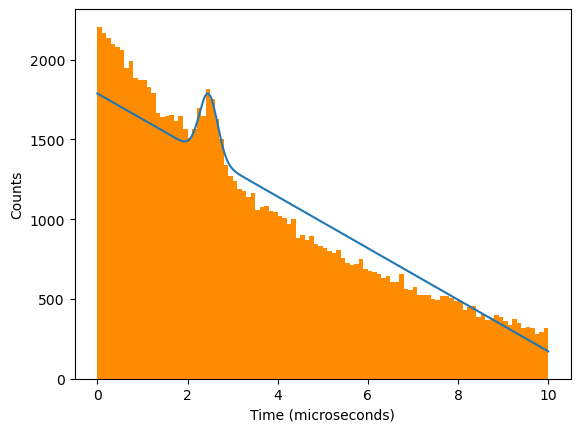

In [20]:
# plot histogram with fitted function
x_2 = np.linspace(0, 10 ,1000)
y_2 = pdf_comb_3(x, m_comb_3.values[0], m_comb_3.values[1], m_comb_3.values[2])

plt.hist(data, bins = 100, color = "darkorange")
plt.plot(x_2, y_2*10000)
plt.xlabel("Time (microseconds)")
plt.ylabel("Counts")
plt.show;